# CNN Hyperparameter Tuning with Bayesian Optimization for MNIST Classification

This example demonstrate the usage of Bayesian optimization (BO) as implemented in scikit-optimize for tuning the hyper parameters of a neural network. As compared to grid search or random search less hyper parameter combinations need to be evaluated to determine the near-optimal configuration.

In each iteration of BO the neural network is trained with a different set of hyper parameters and its validation accuracy is computed. A gaussian process is fitted to the validation accuracy over the space of hyper parameters. An acquistion function which is a function of the fitted gaussian process is sampled for the next suitable hyper parameter combination which is expected to increase validation accuracy.

In [0]:
import tensorflow as tf
import numpy as np
import uuid
import os

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
num_classes = 10

In [0]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [0]:
def create_model(activation, learning_rate, adam_decay, dropout, dense_units, 
                 conv_0_channels, conv_1_channels):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(conv_0_channels, kernel_size=(3, 3),
                  activation=activation,
                  input_shape=input_shape))
  model.add(tf.keras.layers.Conv2D(conv_1_channels, (3, 3), activation=activation))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(dense_units, activation=activation))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr=learning_rate, decay=adam_decay),
                metrics=['accuracy'])
  
  return model

In [0]:
model = create_model(activation="relu", learning_rate=0.01, adam_decay=0.0, dropout=0.25, dense_units=128, 
                 conv_0_channels=32, conv_1_channels=64)

In [10]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 8s 17ms/step - loss: 0.1853 - accuracy: 0.9428 - val_loss: 0.0510 - val_accuracy: 0.9828
Epoch 2/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0802 - accuracy: 0.9760 - val_loss: 0.0471 - val_accuracy: 0.9853
Epoch 3/12
469/469 [==============================] - 7s 16ms/step - loss: 0.0674 - accuracy: 0.9803 - val_loss: 0.0474 - val_accuracy: 0.9852
Epoch 4/12
469/469 [==============================] - 7s 16ms/step - loss: 0.0631 - accuracy: 0.9812 - val_loss: 0.0383 - val_accuracy: 0.9875
Epoch 5/12
469/469 [==============================] - 7s 16ms/step - loss: 0.0575 - accuracy: 0.9823 - val_loss: 0.0420 - val_accuracy: 0.9886
Epoch 6/12
469/469 [==============================] - 7s 16ms/step - loss: 0.0576 - accuracy: 0.9824 - val_loss: 0.0532 - val_accuracy: 0.9867
Epoch 7/12
469/469 [==============================] - 7s 16ms/step - loss: 0.0551 - accuracy: 0.9839 - val_loss: 0.0397 - val_accuracy: 0.9891

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Baysian Optimization

In [0]:
# mount Google Drive first and enter a path where models are stored
root_path = "drive/My Drive/Colab Notebooks/models"

In [13]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 2.5MB/s 


In [0]:
from skopt import gp_minimize, gbrt_minimize
from skopt.utils import use_named_args, dump
from skopt.space import Real, Categorical, Integer 

In [0]:
# define the hyper parameter search space
dim_activation = Categorical(["relu", "tanh", "selu", "elu", "exponential"], name="activation")
dim_learning_rate = Real(1e-5, 1e-1, prior="log-uniform", name="learning_rate")
dim_adam_decay = Real(1e-8, 1e-1, prior="log-uniform", name="adam_decay")
dim_dropout = Real(0.0, 1.0, name="dropout")
dim_dense_units = Integer(32, 512, prior="log-uniform", base=2, name="dense_units")
dim_conv_0_channels = Integer(8, 64, prior="log-uniform", base=2, name="conv_0_channels")
dim_conv_1_channels = Integer(8, 128, prior="log-uniform", base=2, name="conv_1_channels")
dim_batch_size = Integer(1, 256, prior="log-uniform", base=2, name="batch_size")

dimensions  = [dim_activation,
               dim_learning_rate,
               dim_adam_decay,
               dim_dropout,
               dim_dense_units,
               dim_conv_0_channels,
               dim_conv_1_channels,
               dim_batch_size]

#default_parameters = ["relu", 0.01, 0.0, 0.25, 128, 32, 64, 128]  # this yields already quite a good validation accuracy
default_parameters = ["tanh", 0.01, 1e-8, 0.0, 64, 16, 32, 128]  # start with a worse configuration to demonstrate BO

In [0]:
# fit model with default parameters
#model = create_model(*default_parameters[:-1])
#hist = model.fit(x_train, y_train, epochs=8, batch_size=128, validation_data=(x_test, y_test), verbose=1)

In [0]:
# objective function which trains and evaluates the model with a given hyperparameter config 
model_ids = []

@use_named_args(dimensions=dimensions)
def objective(activation, learning_rate, adam_decay, dropout, dense_units, 
              conv_0_channels, conv_1_channels, batch_size):

  model = create_model(activation, learning_rate, adam_decay, dropout, dense_units, 
                 conv_0_channels, conv_1_channels)
  
  model_fitted = model.fit(x_train, y_train, epochs=8, batch_size=batch_size, validation_data=(x_test, y_test), verbose=0)

  accuracy = model_fitted.history["val_accuracy"][-1]

  id = uuid.uuid4()
  model_ids.append(id)
  print("Id {}-- Accuracy: {:.2%}".format(id, accuracy))

  # save weights
  model.save_weights(os.path.join(root_path, 'model-{}'.format(id)) )

  del model
  tf.keras.backend.clear_session()

  return -accuracy

In [62]:
gp_result = gp_minimize(func=objective,
                        dimensions=dimensions,
                        n_calls=12,
                        noise=0.01,
                        n_jobs=-1,
                        kappa=5,
                        x0=default_parameters,
                        random_state=0,
                        verbose=True)

Iteration No: 1 started. Evaluating function at provided point.
Id 907cb0c9-cdd5-493a-804d-6195342af713-- Accuracy: 91.69%
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 28.4040
Function value obtained: -0.9169
Current minimum: -0.9169
Iteration No: 2 started. Evaluating function at random point.
Id 9f2b29f4-8996-464d-9a27-26891d95ba74-- Accuracy: 95.46%
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 145.5839
Function value obtained: -0.9546
Current minimum: -0.9546
Iteration No: 3 started. Evaluating function at random point.
Id 8a8af131-d9f2-4dc3-9b43-bb81e9327805-- Accuracy: 98.43%
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 55.2108
Function value obtained: -0.9843
Current minimum: -0.9843
Iteration No: 4 started. Evaluating function at random point.
Id 97b43ca7-c2d9-4ddf-a8f1-440248fbbb26-- Accuracy: 11.35%
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 72.9718
Function value obtained: -0.1135


NameError: ignored

In [0]:
dump(gp_result, os.path.join(root_path, "BO_result.pkl"))

In [64]:
gp_result.x

['relu',
 0.0006377300155643865,
 1.3801098575179591e-08,
 0.4417109212488455,
 502,
 28,
 66,
 177]

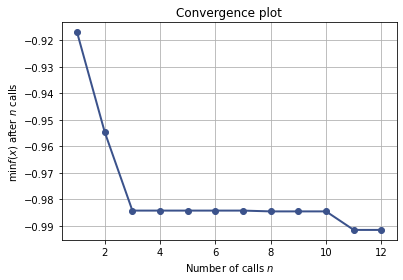

In [68]:
from skopt.plots import plot_convergence
plot_convergence(gp_result)

### Load best model

In [69]:
#best_model_id = "61504fa2-5f6e-4a89-9041-858be90208b7"
best_model_id = model_ids[gp_result.x_iters.index(gp_result.x)]
model_loaded = create_model(*(gp_result.x[:-1]))
model_loaded.load_weights(os.path.join(root_path, "model-{}".format(best_model_id)))

score = model_loaded.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.026339242234826088
Test accuracy: 0.991599977016449


### Retrain the best model

In [0]:
# model_best = create_model(*(gp_result.x[:-1]))
# model_best.fit(x_train, y_train, epochs=8, batch_size=gp_result.x[-1], validation_data=(x_test, y_test), verbose=1)
# score = model_best.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])